# [NTDS'18-project]: Can we estimate the success of a movie?
[ntds'18-project]: https://github.com/rocari96/NTDS-project


#### Team: 40
[Roc Arandes Vilagrasa](https://people.epfl.ch/roc.arandes)
[Hugo Kohli](https://people.epfl.ch/hugo.kohli)
[Romain Caristan](https://people.epfl.ch/romain.caristan)
[Benoît Pasquier](https://people.epfl.ch/benoit.pasquier)



# Introduction

In this project, we attempted to find a way to estimate the earnings of a movie, depending on the company and the people being involved in itincluding actors, directors and producers.

In order to do so, we are employing data that was extracted from the Kaggle dataset. As constructing a good graph is as important as visualizing it, several construction methods will be explored and used to extract as much information as possible.

The nodes of our graph are movies, and this will be a constant throughout the presented work.

# Index

1. [Data loading and description](#1.-Data-description-and-loading)<br>
<br>
2. [Data pre-processing](#2.-Data-pre-processing) <br>
<br>
3. [Average earnings Model](#3.-Average-earnings-Model)<br>
    3.1 [Compute the weights for each feature](#3.1-Compute-the-weights-for-each-feature)<br>
    3.2 [Graph construction](#3.2-Graph-construction)
    > 3.2.1 [Adjacency matrix](#3.2.1-Adjacency-matrix)<br>
    > 3.2.2 [Biggest component](#3.2.2-Biggest-component)<br>
    
    3.3 [Analysis and visualisation](#3.3-Analysis-and-visualisation)<br>
    > 3.3.1 [Graph visualisation on eigenmaps](#3.3.1-Graph-visualisation-on-eigenmaps)<br>
    > 3.3.2 [Signal creation, GFT analysis](#3.3.2-Signal-creation,-GFT-analysis)<br>


4. [BRH Model](#4.-BRH-Model)

    4.1 [BRH-index computation](#4.1-Compute-BRH-Index)<br>
    4.2 [Graph construction: Additioning BRH Index](#4.2-Graph-construction:-Additioning-BRH-Index)
    > 4.2.1 [Adjacency matrix](#4.2.1-Adjacency-matrix)<br>
    > 4.2.2 [Biggest component](#4.2.2-Biggest-component)<br>
    
    4.3 [Analysis and visualisation](#4.3-Analysis-and-visualisation)<br>
    > 4.3.1 [Graph visualisation on eigenmaps](#4.3.1-Graph-visualisation-on-eigenmaps)<br>
    > 4.3.2 [Signal creation, GFT analysis](#4.3.2-Signal-creation,-GFT-analysis)<br>
    > 4.3.3 [Cluster indentification](#4.3.3-Cluster-identification)
    
    4.4 [BRH-index computation without companies](#4.4-BRH-index-computation-without-companies)<br>
    
    4.5 [Graph construction: additioning BRH-index without companies](#4.5-Graph-construction:-additioning-BRH-index-without-companies)<br>
    
    > 4.5.1 [Adjacency matrix](#4.5.1-Adjacency-Matrix)<br>
    > 4.5.2 [Biggest component](#4.5.2-Biggest-component)<br>
    
    4.6 [Analysis and visualisation](#4.6-Analysis-and-visualisation)<br>
    > 4.6.1 [Graph visualisation on eigenmaps](#4.6.1-Graph-visualisation-on-eigenmaps)<br>
    > 4.6.2 [Signal creation, GFT analysis](#4.6.2-Signal-creation,-GFT-analysis)
    
    4.7 [Graph construction: averaging BRH-index without companies](#4.7-Graph-construction:-averaging-BRH-index-without-companies)<br>
    > 4.7.1 [Adjacency Matrix](#4.7.1-Adjacency-Matrix)<br>
    > 4.7.2 [Biggest component](#4.7.2-Biggest-component)<br>
    
    4.8 [Analysis and visualisation](#4.8-Analysis-and-visualisation)<br>
    > 4.8.1 [Graph visualisation on eigenmaps](#4.8.1-Graph-visualisation-on-eigenmaps)<br>
    > 4.8.2 [Signal creation, GFT analysis](#4.8.2-Signal-creation,-GFT-analysis)
    

        
5. [Conclusion](#5.-Conclusion)

In [1]:
#Import of the different packages needed for the project:

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import networkx as nx
import math
from scipy import sparse

In [2]:
%matplotlib inline

In [3]:
seed = 3

---
# 1. Data description and loading 
[Back to index](#Index)

As stated in the introduction, during this project we have chosen to continue to work with the [`TMDB 5000 Movie Dataset`](https://www.kaggle.com/tmdb/tmdb-movie-metadata/home) from Kaggle. This one, being already a subset of the more complete [`TMDB Dataset`](https://www.imdb.com/interfaces/), allowed us to reduce the computational time of the different methods shown in the following chapters.

The `TMDB 5000 Movie Dataset` is composed of two source files:

**tmdb_5000_credits.csv** with the following features:
- movie_id
- title
- cast
- crew

and **tmdb_5000_movies.csv** with the following features:
- budget
- genres
- homepage
- id
- keywords
- original_language
- original_title
- overview
- popularity

Both files have been used mostly during the pre-processing and preparation steps in order to create the different graphs shown in this notebook.

In [4]:
data_path = 'data/'

In [5]:
# Loading the Kaggle data
movies_path = data_path + 'tmdb-5000-movie-dataset/'
credits = pd.read_csv(movies_path + 'tmdb_5000_credits.csv')
movies = pd.read_csv(movies_path + 'tmdb_5000_movies.csv')

credits = credits.rename(columns={'movie_id': 'id'})

# merge the two data set credit and movies
movies = movies.merge(credits, how='inner', on='id')

In [6]:
# First state of the dataframe movies, before adapting it to our needs.
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


---
# 2. Data pre-processing
[Back to index](#Index)

In the following chapter, the data extracted from [`TMDB 5000 Movie Dataset`](https://www.kaggle.com/tmdb/tmdb-movie-metadata/home) will be pre-processed and prepared so that all the information that is required later during the project will be easily accessible:

In the first place, the data is not complete and sometimes the units (of budget and revenue) are not consistent, therefore we need to check and remove the movies if it is the case.

In [7]:
# Check and Drop 0 budget or revenue movies (corresponds to unknown values)
before = len(movies)
movies = movies[(movies['budget'] != 0) & (movies['revenue'] != 0)]
print('{} movies were dropped ({}%).'.format(before-len(movies), 100*(before-len(movies))/before))

1574 movies were dropped (32.77118467624401%).


Additionally we created another feature for each movie that is the return on the initial investment, henceforth called `earnings`.

In [8]:
movies['earnings'] = (movies['revenue'] - movies['budget']) / movies['budget']

Moreover, the other features provided by Kaggle that are not used for this project such as `original_language` or `runtime` are dropped.

In [9]:
# keep only useful features
movies = movies[['original_title', 'budget', 'revenue', 'earnings', 'production_companies', 'cast', 'crew']]
movies.head(5)

,original_title,budget,revenue,earnings,production_companies,cast,crew
0,Avatar,237000000,2787965087,10.763566,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,300000000,961000000,2.203333,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,245000000,880674609,2.594590,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,The Dark Knight Rises,250000000,1084939099,3.339756,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,John Carter,260000000,284139100,0.092843,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


After ordering the movies by `earnings` and analyzing the data, we can observe that some of the values in the budget and revenue columns are expressed in millions whereas most of the values are raw numbers. Thus, we chose to remove the values expressed in millions for more consistency of the future results. This is done by selecting only the movies that have a budget and revenue bigger than 1000 (it is yet unknown that a movie has had a budget and a revenue more than a billion dollars).

In [10]:
prev_len = len(movies)
movies = movies[(movies['budget'] > 1000) & (movies['revenue'] > 1000)].reset_index(drop=True)
n_movies = len(movies)
print(f'The number of deleted movies is: {prev_len - n_movies}, representing the {100*(prev_len - n_movies)/prev_len}% of the data')

The number of deleted movies is: 18, representing the 0.5574481263549086% of the data


We can see in the previous cell that this deletion represents 18 movies (~0.6% of the data). Moreover, we can observe in the following cell the movies that have the highest earning after deleting these 18 movies.

In [11]:
movies.sort_values(by='earnings', ascending=False).head()

,original_title,budget,revenue,earnings,production_companies,cast,crew
3158,Paranormal Activity,15000,193355800,12889.386667,"[{""name"": ""Blumhouse Productions"", ""id"": 3172}...","[{""cast_id"": 3, ""character"": ""Katie"", ""credit_...","[{""credit_id"": ""52fe4477c3a368484e024b01"", ""de..."
3142,The Blair Witch Project,60000,248000000,4132.333333,"[{""name"": ""Artisan Entertainment"", ""id"": 2188}...","[{""cast_id"": 41, ""character"": ""Mike"", ""credit_...","[{""credit_id"": ""52fe4364c3a36847f8050c01"", ""de..."
3200,Eraserhead,10000,7000000,699.000000,"[{""name"": ""American Film Institute (AFI)"", ""id...","[{""cast_id"": 13, ""character"": ""Henry Spencer"",...","[{""credit_id"": ""52fe4296c3a36847f802a5dd"", ""de..."
3207,Pink Flamingos,12000,6000000,499.000000,"[{""name"": ""Dreamland Productions"", ""id"": 407}]","[{""cast_id"": 8, ""character"": ""Divine / Babs Jo...","[{""credit_id"": ""52fe426bc3a36847f801d203"", ""de..."
3202,Super Size Me,65000,28575078,438.616585,"[{""name"": ""Kathbur Pictures"", ""id"": 8735}]","[{""cast_id"": 1, ""character"": ""Himself"", ""credi...","[{""credit_id"": ""52fe44efc3a36847f80b2a9d"", ""de..."


For the rest of the project, we have chosen to keep the 5 first actors, 5 first characters, the director, the producer and the company name (which will be considered as a person in the first model). 

The number of actors per film that are kept is a subjective choice and could be changed if wanted. Nevertheless, we believe that no more than the first 5 roles in a film play a preponderant role in the success of the film.

In [12]:
to_keep = 5

# extracting the data from json format
movies['actors'] = movies.cast.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:to_keep])
movies['characters'] = movies.cast.map(lambda x: list(map(lambda d: d['character'], json.loads(x)))[:to_keep])
movies['crew'] = movies.crew.map(lambda x: list(filter(None, list(map(lambda d: d['name'] if (d['job'] == 'Director' or d['job'] == 'Producer') else None, json.loads(x))))))
movies['production_companies'] = movies.production_companies.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:1])

# Keeping only usefull series in dataframe
movies = movies[['original_title', 'earnings', 'production_companies', 'actors', 'characters', 'crew']]
movies_no_comp = movies[['original_title', 'earnings', 'actors', 'characters', 'crew']]

# merging series in a features serie
movies['features'] = movies['production_companies'] + movies['actors'] + movies['characters'] + movies['crew']
movies_no_comp['features'] = movies_no_comp['actors'] + movies_no_comp['characters'] + movies_no_comp['crew']

# removing now useless series
movies = movies[['original_title', 'earnings', 'features']]
movies_no_comp = movies_no_comp[['original_title', 'earnings', 'features']]
movies_no_comp.head()

# movies = dataframe including all the previously described features (actors, characters, director, producer and company name)
# movies_no_comp = contains the same information that movies but the companies are removed. (used further in the notebook)

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,original_title,earnings,features
0,Avatar,10.763566,"[Sam Worthington, Zoe Saldana, Sigourney Weave..."
1,Pirates of the Caribbean: At World's End,2.203333,"[Johnny Depp, Orlando Bloom, Keira Knightley, ..."
2,Spectre,2.594590,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R..."
3,The Dark Knight Rises,3.339756,"[Christian Bale, Michael Caine, Gary Oldman, A..."
4,John Carter,0.092843,"[Taylor Kitsch, Lynn Collins, Samantha Morton,..."


In [13]:
movies['earnings'].describe()

count     3211.000000
mean        10.141042
std        240.069277
min         -0.999744
25%          0.030258
50%          1.303478
75%          3.420937
max      12889.386667
Name: earnings, dtype: float64

In the previous cell, we can observe that at least 50% of the movies contained in our dataset have earned at least x1.3 times the amount of money they spent in the budget.

---
# 3. Average earnings Model
[Back to index](#Index)

In this following chapter, the first model with which we attempted to estimate the earnings of a movie will be presented an analysed. 

First, the method of computing the weights for each feature (actor / character / director / producer / company) will be presented. Second, the adjacency matrix and its biggest component will be calculated and briefly discussed. Furthermore, the normalized eigenvectors of the biggest component will be calculated and used visualize our data, and also to provide a GFT between the created graph and a `labels` signal representing a certain treshold of earnings. Finally, the results and their consequences will be analysed and discussed.

## 3.1 Compute the weights for each feature
[Back to index](#Index)

In this following subsection, the edges of the first method are computed. The 5 first actors, 5 first characters, the director, the producer and the company name are taken into account. 

By doing a computation over all the movies, each person/company is assigned a weight, which is the average of the earnings over all the movies in which he/she has contributed. 

In [14]:
# A DataFrame where each row contains only one feature (actor, character or production company)
# Easier for later computations
earning_movies = movies.set_index(['original_title', 'earnings'])['features'].apply(pd.Series).stack().reset_index().drop('level_2', axis=1).drop_duplicates()
earning_movies.columns = ['original_title', 'earnings', 'feature']

As some of the participating members of a movie had more than one role (i.e director & producer), the duplicated values are dropped.

In [15]:
#Example of the data structure in the dataframe earning_movies: 
earning_movies[earning_movies['feature'] == 'Christopher Nolan']

,original_title,earnings,feature
57,The Dark Knight Rises,3.339756,Christopher Nolan
216,Man of Steel,1.945980,Christopher Nolan
980,The Dark Knight,4.430046,Christopher Nolan
1403,Interstellar,3.091636,Christopher Nolan
1418,Inception,4.159580,Christopher Nolan
1777,Batman Begins,1.494791,Christopher Nolan
14396,Insomnia,1.472062,Christopher Nolan
16538,The Prestige,1.741908,Christopher Nolan
40256,Memento,3.413677,Christopher Nolan


In [16]:
#Definition of the function that computes the weights of each person and saves the data into a *.csv file.

def compute_features_weight(movies, data_type):
    try:
        features = pd.read_csv(data_path + 'features_' + data_type + '.csv')
    except FileNotFoundError: 
        # Create the features table with their weights associated weights (set to 0).
        features = set(movies['features'].sum())
        features.discard('')
        features = list(features)
        features.sort()
        features = pd.DataFrame(features, columns=['feature'])
        
        features['weight'] = 0
        for i, feature in enumerate(features['feature']):
            in_movie = earning_movies[earning_movies['feature'] == feature]
            features.loc[i, 'weight'] = in_movie['earnings'].sum() / len(in_movie)
            
        features.to_csv(data_path + 'features_' + data_type + '.csv')
    return features

In [17]:
features = compute_features_weight(movies, 'full')

The dataframe `features` is essential as it contains the list of every single person that has contributed in any of the movies of our dataset, with the `weight` they have been attributed following the previously described method

In [18]:
features.head()

,Unnamed: 0,feature,weight
0,0,Larry Mullen Jr.,0.515389
1,1,"""Drugs"" Delaney",0.041739
2,2,"""Hickory"" / The Tin Man",11.155192
3,3,"""Hunk"" / The Scarecrow",11.155192
4,4,"""Whistling"" John Shaw",-0.487703


By investigating the dataframe `features`, we can observe that the people that appear on top of the list are the actors of Paranormal Activity (the highest earnings movie in our list). These ones are highly advantaged by the used model, as they are probably amateur actors (having only participed in a small amount of movies) and therefore the success of a single movie (Paranormal Activity) puts them on top of the list.

## 3.2 Graph construction
[Back to index](#Index)

## 3.2.1 Adjacency matrix
[Back to index](#Index)

In this subsection, the `features` dataframe is used in order to calculate the weight of the edges of our first adjacency matrix. These ones, consist of the sum of the weights of the common people between the two movies in question.

In [19]:
def compute_adjacency(name, model, movies, features, average):
    try:
        adjacency = np.load(data_path + name)

    except FileNotFoundError: 
        adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
        for i in range(n_nodes):
                # as the adjacency matrix is symmetric, only the upper triangular is calculated to save time
                for j in range(i, n_nodes):
                    # create weighted edges as the shared number of actors between movies
                    common_actors = set(movies['features'][i]).intersection(set(movies['features'][j]))
                    sum_weights = 0.0
                    counter = 0
                    for actor in common_actors :
                        if (features['feature'].isin([actor]).any()):
                            counter = counter + 1
                            sum_weights = sum_weights + features[features['feature'] == actor][model].item()
                    if (average):
                        sum_weights = sum_weigths/counter
                    adjacency[i, j] = sum_weights

        # fill the lower triangular 
        adjacency += np.transpose(adjacency)

        np.fill_diagonal(adjacency, 0, wrap=False)
        
        np.save(data_path + name, adjacency)
    return adjacency

In [20]:
n_nodes = len(movies)
adjacency = compute_adjacency('adjacency.npy', 'weight',movies,features,False)

print('Our graph contains {} movies.'.format(n_nodes))

Our graph contains 3211 movies.


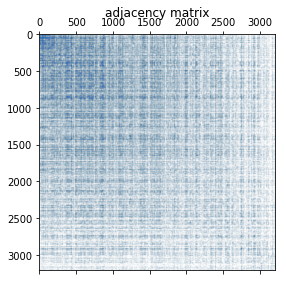

In [21]:
plt.spy(adjacency, markersize=0.01)
plt.title('adjacency matrix');
plt.tight_layout()

We first want to evaluate some characteristics of our adjacency, so we can later have a quick understanding of how the models differ between them:

L_max = 5153655.0
L = 353484
Sparsity = 0.9314110083038154
Average degree =  110.08533167237621


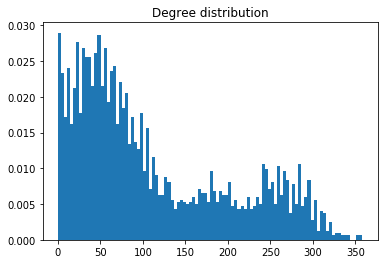

In [22]:
# maximum number of Links in our network
L_max = n_nodes*(n_nodes-1)/2
print('L_max =', L_max)

# number of link in our network
L = np.count_nonzero(adjacency)
print('L =',L)

# sparisty
sparsity = (L_max-L)/L_max
print('Sparsity =', sparsity)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary = adjacency.astype(bool).astype(int)
degree = np.sum(adj_binary, axis=0)

print('Average degree = ', np.mean(degree))

#Histogram of degree distribution
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights, bins = 100);
plt.title('Degree distribution');

Our network is really sparse, it is not a surprise as actors, director or producer are still human and cannot play in an extensive number of movies and the dataset we have chosen to work with should be representative of all movies and the diversity is really high.

The degree distribution indicates us that the majority of movies have in general less than 100 connections, and are more independant productions.

## 3.2.2 Biggest component
[Back to index](#Index)

In this section, the functions needed to extract the biggest component of an adjacency matrix are defined. While we know that this one can be obtained using NetworkX, we have prefered to use our own functions which allow more easily to extract the indexes of the nodes that belong to the biggest component.

In [23]:
def adj_matrix_to_list(adj):
    """Transform adjacency matrix into a dictionnary : each node is linked with all his neighbor nodes
    
    Parameters
    ----------
    adj:       adjacency matrix 
    
    Returns
    -------
    adj_list : dictionnary
    
    """
    
    adj_list = {} 
    for node, nodes in enumerate(adj):
        neighbors = []
        for next_node, weighted_edge in enumerate(nodes):
            if weighted_edge:
                neighbors.append(next_node)
        adj_list[node] = neighbors
    return adj_list

In [24]:
def bfs(adj_list, start, labels, l=1):
    
    """Apply the BFS algorithm 
    
    Parameters
    ----------
    adj_list:       Adjacency matrix transformed to a list (see ajd_matrix_to_list)
    start:          Starting node
    labels :        Information whether a node has been visited or not
    
    Returns
    -------
    labels :         contain the information whether a node has been visited or not
    bool connected : True if the graph is connected, False otherwise.
    visited :        a list of all the visited nodes
    
    """
    
    
    nodes = list(labels.keys())
    #q is a queue, it contains the next node to be inspected (initialized with the starting node)
    q = []
    q.append(start)
    #label contains for each node l (if the node has already been inspected) or 0
    labels[start] = l
    
    #while there is nodes to inspect
    while len(q):
        node = q.pop(0)
        
        #inspect all the nodes linked to 'node'
        for neighbor in adj_list[node]: 
            #if it has not already been inspected, add it to the queue, and label it to 1
            if labels[neighbor] == 0: 
                q.append(neighbor)
                labels[neighbor] = l
    #contains all the connected nodes
    visited = {node: label for (node, label) in labels.items() if label !=0} 
    connected = len(visited) == len(nodes)
    return labels, connected, visited

In [25]:
def find_components(adjacency):
    
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    components = list()
    # transform the adjacency matrix into an adjacency list where the weights are ignored
    adj_list = adj_matrix_to_list(adjacency) 
    
    # l: the label of the components
    l = 1
    
    # select a random node to start exploring the graph
    start = np.random.choice(list(adj_list.keys()))
    nodes = list(adj_list.keys())
    
    # apply BFS to label the nodes of the first component and to know if the graph is connected
    labels, visited_all, _ = bfs(adj_list, start, {node: 0 for node in nodes})
    visited = [node for node, label in labels.items() if label == l]
    components.append(adjacency[visited, :][:, visited]) 
    
    # while we did not label every node
    while not visited_all:
        l += 1
        to_visit = [node for node, label in labels.items() if label == 0]
        start = np.random.choice(list(to_visit))
        # apply new BFS to explore new component
        labels, visited_all,_ = bfs(adj_list, start, labels, l)
        visited = [node for node, label in labels.items() if label == l]
        components.append(adjacency[visited, :][:, visited]) 
    
    # the list of all components sorted by descending size 
    components.sort(key=lambda mat: mat.shape, reverse=True)    
    return components, labels

In [26]:
# Function that calculates the biggest component (given the adjacency) and saves it into a *.npy array:

def compute_bc(name, adjacency):
    try:
        bc_nparray = np.load(data_path + name)
        nodes_bc = np.load(data_path + 'nodes_' + name)
    
    except FileNotFoundError:
        components, labels = find_components(adjacency)
        bc_nparray = components[0]
        label_count = np.unique(np.fromiter(labels.values(), dtype=int), return_counts=True)
        lab_dict = dict(zip(label_count[0], label_count[1]))
        label_bc = max(lab_dict, key=lab_dict.get)
        nodes_bc = [node for node, label in labels.items() if label == label_bc]
        np.save(data_path + name, bc_nparray)
        np.save(data_path + 'nodes_' + name, nodes_bc)

    return bc_nparray, nodes_bc

In [27]:
bc_nparray, nodes_bc = compute_bc('bc', adjacency)

n_nodes_bc = len(nodes_bc)

print('The size of the largest component is {}.'.format(n_nodes_bc))

The size of the largest component is 3167.


In [28]:
G = nx.from_numpy_array(bc_nparray)

print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G))

Clustering coefficient of our Biggest Component = 0.4873697052213142


In [29]:
movies_bc = movies.loc[nodes_bc, :]
movies_bc['earnings'].describe()

count     3167.000000
mean        10.252519
std        241.728974
min         -0.999744
25%          0.047413
50%          1.320008
75%          3.422960
max      12889.386667
Name: earnings, dtype: float64

When observing the previous cell, we can see that `movies_bc` (a dataframe structured like `movies` but only containing those present in the BC) description values haven't changed much. The percentages of movies that have earned more than x1.3 times the available budget has remained the same.

## 3.3 Analysis and visualisation
[Back to index](#Index)

## 3.3.1 Graph visualisation on eigenmaps
[Back to index](#Index)

The first step, is to define a function that loads (if they are already saved) or computes the Normalized Laplacian and the gradient and saves them into sparsed `*.npz` files. 

In [30]:
def compute_gradient_laplacian(name, bc_nparray, degree_biggest_component, N, E):
    try:
        gradient = scipy.sparse.load_npz(data_path + name)
        sparse_gradient = sparse.csr_matrix(gradient)

    except FileNotFoundError:
        # Let us compute the gradient
        gradient = np.zeros((E, N))
        eij = 0  # edge index

        for i in range(N):
            for j in range(N):
                wij = bc_nparray[i, j]
                if wij > 0:
                    gradient[eij,i] = math.sqrt(wij)/math.sqrt(2*degree_biggest_component[i])
                    gradient[eij,j] = -math.sqrt(wij)/math.sqrt(2*degree_biggest_component[j])
                    eij = eij + 1  # increment the edge index 
        sparse_gradient = sparse.csr_matrix(gradient)
        scipy.sparse.save_npz(data_path + name, sparse_gradient)
        
    laplacian = (gradient.T@gradient) #Laplacian Normalisé calculé avec le gradient.
    sparse_laplacian = sparse.csr_matrix(laplacian)
        
    return sparse_gradient, sparse_laplacian

In [31]:
degree_biggest_component= np.sum(bc_nparray, axis=0)

N = n_nodes_bc  # number of nodes
E = np.sum(bc_nparray > 0)  # number of edges (non-zero entries of A)

sparse_gradient, sparse_laplacian = compute_gradient_laplacian('gradient.npz', bc_nparray, degree_biggest_component, N, E)   

In [32]:
eigenvalues, eigenvectors = np.linalg.eigh(sparse_laplacian.toarray())
e = eigenvalues
U = eigenvectors

D = np.diag(degree_biggest_component)
D_inv = np.divide(1,D)
D_inv[D_inv == np.inf] = 0
D_sqrtinv = scipy.linalg.sqrtm(D_inv)

#Renormalized by the degrees
U_norm = D_sqrtinv@U

# Normalize the rows of U_norm
rows_norm = np.linalg.norm(U_norm, axis=1, ord=2)
U_norm = (U_norm.T / rows_norm).T

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In the previous cell, the `eigenvectors, eigenvalues` are computed using `np.linalg.eigh` and they are also re-normalized by the `degree_biggest_component` and also by the rows of `U_norm`.

Furthermore, in the following cell the first two eigenvectors of non-null eigenvalues are used to plot our graph:

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


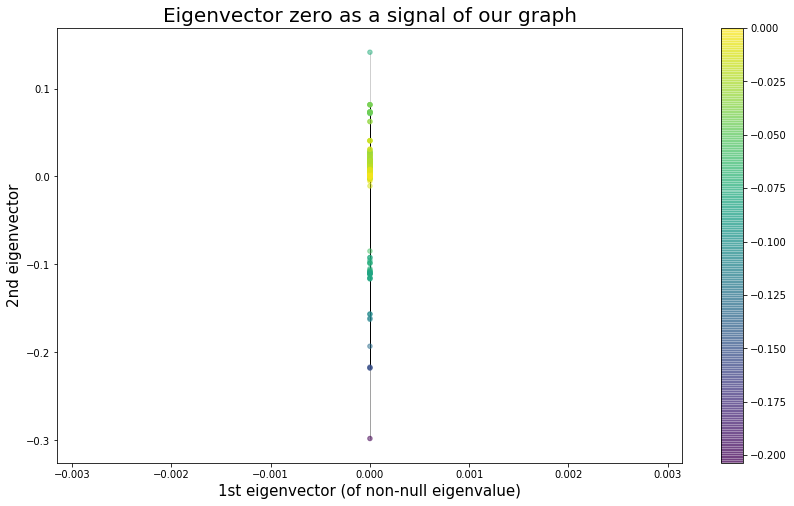

In [33]:
plt.figure(figsize=(14,8))
coords = U_norm[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G, coords,alpha=0.5, node_size=20, node_color=U_norm[:,0])
nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

# !?!?!?! FAUT SAVOIR SI C'EST NORMAL D'ETRE 100% SUR LE 2ND EIGENVECTOR, ET SI OUI, EN FAIRE UN PETIT ANALYZE

## 3.3.2 Signal creation, GFT analysis
[Back to index](#Index)


### Signal creation

As a first approach, we choose to use binary labels as our signal. A threshold is used to separate the earnings in a `+1` (earning bigger than the threshold) or `-1` (earning smaller than the threshold) signal. Different threshold values are  explored and the corresponding signals will be observed on the graph.

In [34]:
label_threshold = 2

In [35]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation(threshold):
    labels = np.zeros(n_nodes_bc, dtype=float)
    labels[movies_bc['earnings'] >= threshold] = 1
    labels[movies_bc['earnings'] < threshold] = -1
    return labels

In [36]:
labels_bc = labels_creation(label_threshold)
lab_bc_count = np.unique(labels_bc, return_counts=True)
dict(zip(lab_bc_count[0], lab_bc_count[1]))

{-1.0: 1907, 1.0: 1260}

### Fourier analysis

In order to better visualize the labels on our graph and to check if our graph could potentially be separable, a GFT between the `labels` signal and the eigenvectors previously obtained is calculated.

Then, the GFT is used to extract which eigenvectors have the highest correlation with our `labels` signal, and these ones are further used to visualize the data.

In [37]:
def GFT(x,N,U_norm):
    gft = np.zeros(N)
    for i in range(N):
        gft[i] = np.dot(x,U_norm[:,i])
    return gft 

def iGFT(x,N,U_norm):
    igft = np.zeros(N)
    for i in range(N):
            igft[i] += np.dot(x,U_norm[i,:])
    return igft

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


<StemContainer object of 3 artists>

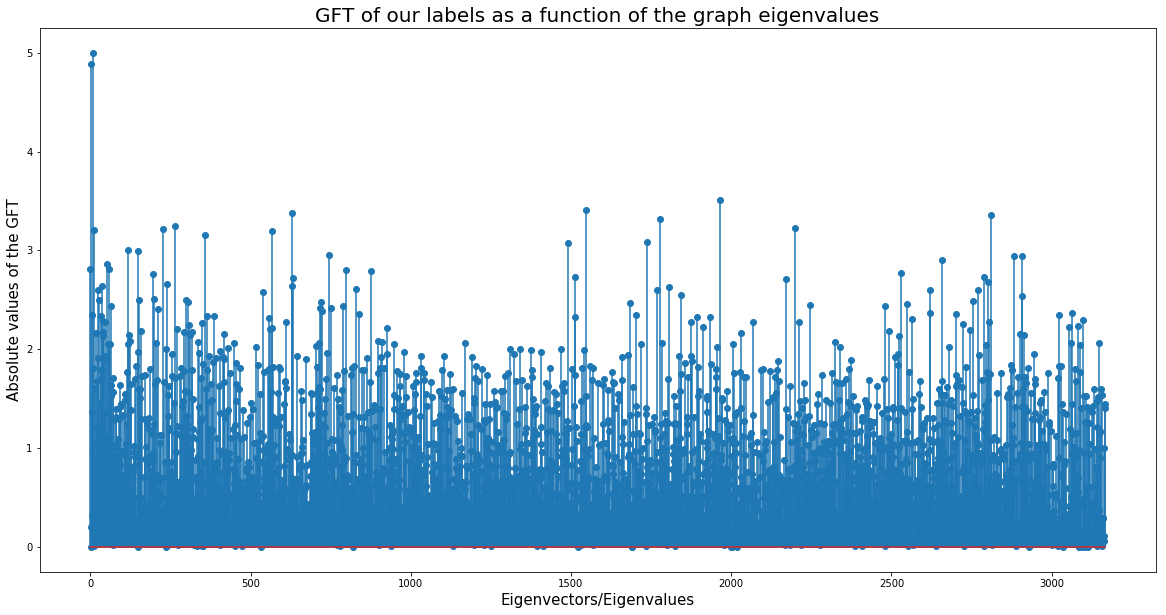

In [38]:
gft = GFT(labels_bc,N,U_norm)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our labels as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)

# PETIT ANALYSE AUSSI FREQUENCIEL, dire que le signal n'agit pas comme un LOW-Pass filter etc, etc... Checker le COURS

### Visualisation of the signal `labels` on laplacian eigenmaps with most representative eigenvectors

In [39]:
# getting the indexes of the 10 eigenvectors with the highest correlation
index_eig = gft_abs.argsort()[-10:][::-1]
index_eig

array([   8,    2, 1966, 1546,  630, 2812, 1778,  263, 2200,  226])

Furthermore, various eigenmap visualizations consisting of the different possible combinations of the 3 most representative eigenvectors are shown:

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


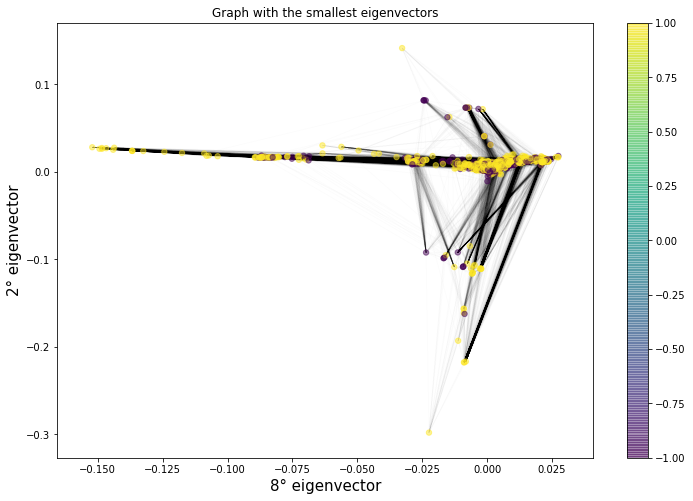

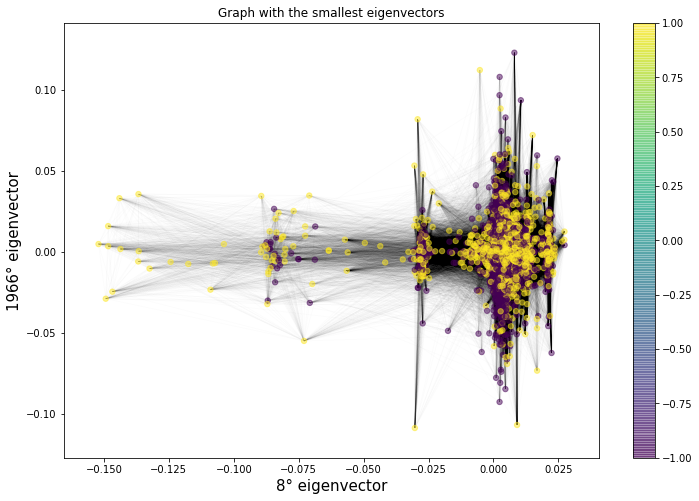

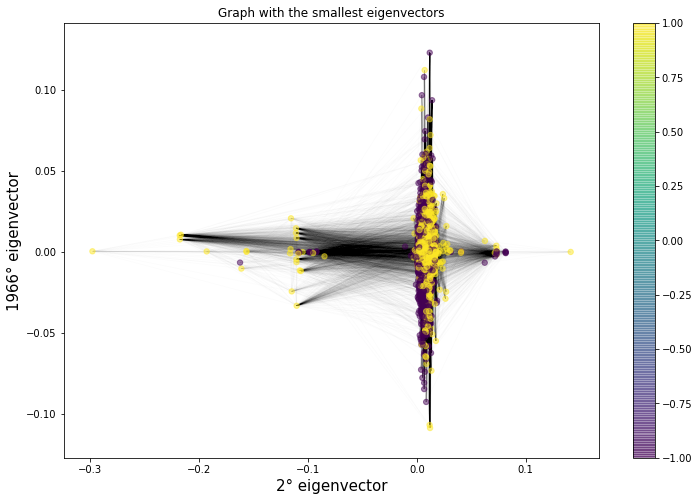

In [40]:
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(12,8))
        coords = U_norm[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G, coords,alpha=0.5 ,node_size=29, node_color=labels_bc)
        nx.draw_networkx_edges(G, coords, alpha=0.01)
        plt.title('Graph with the smallest eigenvectors')
        plt.xlabel('{}° eigenvector'.format(index_eig[i]), fontsize=15);
        plt.ylabel('{}° eigenvector'.format(index_eig[j]), fontsize=15);
        plt.colorbar(nx_nodes);

As we can see on these plots, this first proposed method of creating a graph does not seems to be appropriate to answer our initial question.

Indeed, apart from some outliers that are distant the others, there is no clear cluster in our graph. The nodes are just huddled in a big group, and therefore, regardless of the threshold used to create the labels, no information about the earning can be drawn from the graph.

This model has one big inconvenient, which could be the reason why the earnings cannot be extracted at all. Indeed, if a person played in a single movie who had a very big income compared to its budget, the weight of this person is very high.

For example, the movie "Paranormal Activity" is the movie with the biggest earning in this dataset. Therefore, the five main actors who played in this movie, are the subjects with the highest weight of all the people among all the films (as shown in the following cell), even bigger than Brad Pitt for example. However, they are far from being the most famous actrors, and one can reasonnably think that its impact in a movie cannot be as important as its computed weight suggests. 

From this point, we thought that another way to attribute a weight to the people should be found, and we came with a solution that is described in details in the following chapter.

In [41]:
features.sort_values(by='weight', ascending=False).head()

,Unnamed: 0,feature,weight
15145,15145,Mark Fredrichs,12889.386667
1639,1639,Ashley Palmer,12889.386667
15920,15920,Micah Sloat,12889.386667
922,922,Amir Zbeda,12889.386667
885,885,Amber Armstrong,12889.386667


---
# 4. BRH Model
[Back to index](#Index)

As we could see in the previous chapter, we were not able to extract any remarkable information using the weights obtained with the previously introduced model. Therefore, we decided to create a novel way of computing an index that represents somehow the economical impact and the consistency that an actor/character/director/company has when participating in a movie production. 

In order to do so, we were inspired by the mathematical model "h-index" used in the scientific community to measure the impact of the creations (papers) of a researcher in the scientific community.

Nevertheless, some considerations were taken into account in order to represent the nature of a graph.

The procedure was the following: 

1. The list of all movies with their corresponding earnings for a certain feature (actor/character/director/producer/company) was retrieved.



2. The list of movies per feature was divided in two lists consisting of those who had positive earnings and those who had negative earnings (i.e lost money).



3. In order to scale up the precision of our model, the earnings were upscaled of 100 (representing the %) and the positive and negative separate indexes were calculated.



4. If an actor had a positive index of 25, this meant that he/she participated in at least 25 movies that made at least x2.5 earnings. Similarly, if an actor had a negative index of 5, this would mean that he had participated in 5 movies that at least lost x0.5 their budget.



5. Finally, these two indices were added and a final index, that we named the BRH-Index was attributed to each actor.


6. In order to be able to use these values to construct a graph, an positive shitft needed to be added so that the minimum value of a BRH-Index would be 0. This was needed as a negative value in an edge would represent a directed graph.

This model attempts to better represent the real economic impact of an individual person, giving less importance to people such as Amber Armstrong who only appear in one successful movie, and giving more importance to consistency and perserverance.

## 4.1 Compute BRH Index
[Back to index](#Index)

In [42]:
# BRH_index created and owned by BRH Index Corp. MIT License. For business inquires, please contact our secretary Romain le BG
def brh_index_calculator(name):
    
    
    """Apply the BRH index algorithm 
    
    Parameters
    ----------
    name: name of the actor/character/production company
    
    Returns
    -------
    brh_index : quantify the impact of a feature as a function of the revenue of the films in which it was involved
 
    """
    
    
    brh_index = 0
    brh_index_p = 0
    brh_index_n = 0
    
    earnings_feature = pd.DataFrame(earning_movies[earning_movies['feature'] == name]['earnings'])
    
    positive_earnings = earnings_feature[earnings_feature > 0].dropna().sort_values(['earnings'], ascending = False)
    positive_earnings = 100*positive_earnings.reset_index(drop=True)



    if (len(positive_earnings['earnings']) == 1):
        if (positive_earnings['earnings'][0] >= 1):
            brh_index_p = 1
        else:
            brh_index_p = round(positive_earnings['earnings'][0])
    else:
        for i in range(len(positive_earnings['earnings'])) :
            if len(positive_earnings[positive_earnings['earnings'] >= positive_earnings['earnings'][i]]) >= round(positive_earnings['earnings'][i]) :
                brh_index_p = i
                break
        

    negative_earnings = earnings_feature[earnings_feature < 0].dropna().sort_values(['earnings'], ascending = True)
    negative_earnings = negative_earnings.reset_index(drop=True)
    negative_earnings = 100* abs(negative_earnings)

    if (len(negative_earnings['earnings']) == 1):
        if (negative_earnings['earnings'][0] >= 1):
            brh_index_n = 1
        else:
            brh_index_n = round(negative_earnings['earnings'][0])
    else:
        for i in range(len(negative_earnings['earnings'])) :
            if len(negative_earnings[negative_earnings['earnings'] >= negative_earnings['earnings'][i]]) >= round(negative_earnings['earnings'][i]) :
                brh_index_n = i
                break
        

    brh_index = brh_index_p - brh_index_n
    return brh_index

In [43]:
def compute_features_brh(movies, data_type):
    try:
        features = pd.read_csv(data_path + 'features_brh_' + data_type + '.csv')
    except FileNotFoundError: 
        # Create the features table with their weights associated weights (set to 0).
        features = set(movies['features'].sum())
        features.discard('')
        features = list(features)
        features.sort()
        features = pd.DataFrame(features, columns=['feature'])
        
        features['brh_index'] = features['feature'].apply(lambda f: brh_index_calculator(f))
        features['brh_index'] = features['brh_index'] + abs(min(features['brh_index']))
        
        features.to_csv(data_path + 'features_brh_' + data_type + '.csv')
    return features

In [44]:
features = pd.concat([features, compute_features_brh(movies, 'full')['brh_index']], axis=1)

The found BRH-Index per feature was added to the previously created `features` dataframe already containing the previously used weights.

Finally, we can show the recently modified features using the newly created BRH-Index as descending order.

In [45]:
features.sort_values(by='brh_index', ascending=False).head(20)

,Unnamed: 0,feature,weight,brh_index
23505,23505,Universal Pictures,3.901744,123.0
17856,17856,Paramount Pictures,4.439880,114.0
23392,23392,Twentieth Century Fox Film Corporation,3.778530,105.0
4573,4573,Columbia Pictures,1.878315,94.0
17181,17181,New Line Cinema,8.538247,81.0
23882,23882,Walt Disney Pictures,2.663880,72.0
23503,23503,United Artists,10.830685,59.0
6635,6635,DreamWorks SKG,2.315972,47.0
7818,7818,Fox Searchlight Pictures,4.725724,45.0
23716,23716,Village Roadshow Pictures,1.475530,42.0


While we expected our BRH-Index to work better than the previoulsy used weights, the results are nevertheless astonishing! 

We can see that in fact the most known companies are on the top on the list. And the most known actors and directors (such as Steven Spielberg, Brad Pitt or Tom Hanks) appear just after them. As an interesting reminder, this index was calculated using the earnings, meaning that no advantage was given to "known" actors that usually participate in high-budget movies over more independent ones, but we still find the people that we would expect to be on top, on top.

## 4.2 Graph construction: Additioning BRH Index
[Back to index](#Index)

## 4.2.1 Adjacency matrix
[Back to index](#Index)

The first (and probably naive) approach to calculate the edges with the newly created BRH Index was to simply add the BRH index of the common members between the two movies in question.

After doing this, a procedure similar to the one previously explained for the first model is followed:

In [46]:
adjacency_brh = compute_adjacency('adjacency_brh.npy', 'brh_index',movies, features, False)

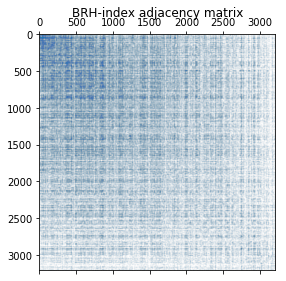

In [47]:
plt.spy(adjacency_brh, markersize=0.01)
plt.title('BRH-index adjacency matrix');
plt.tight_layout()

L_max = 5153655.0
L = 353484
Sparsity = 0.9280308829364791
Average degree =  115.51043288695111


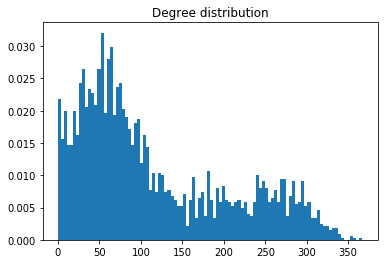

In [48]:
# maximum number of Links in our network
L_max_brh = n_nodes*(n_nodes-1)/2
print('L_max =', L_max_brh)

# number of link in our network
L_brh = np.count_nonzero(adjacency_brh)
print('L =',L)

# sparisty
sparsity_brh = (L_max_brh-L_brh)/L_max_brh
print('Sparsity =', sparsity_brh)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary_brh = adjacency_brh.astype(bool).astype(int)
degree_brh =  np.sum(adj_binary_brh, axis=0)

print('Average degree = ', np.mean(degree_brh))


#Histogram of degree distribution
weights_brh = np.ones_like(degree_brh) / float(n_nodes)
plt.hist(degree_brh, weights=weights_brh, bins = 100);
plt.title('Degree distribution');

The new netwrork is also really sparse. 
If we compare this degree distribution with the previous one from section [3.2.1](#3.2.1-Adjacency-matrix) we can see that we have less movies with a low degree. Why that ??????????????????????????????????????????????????????????????????????????????

## 4.2.2 Biggest component
[Back to index](#Index)

In [49]:
bc_nparray_brh, nodes_bc_brh = compute_bc('bc_nparray.npy', adjacency_brh)

In [50]:
n_nodes_bc_brh = len(nodes_bc_brh)

print('The size of the largest component is {}.'.format(n_nodes_bc_brh))

The size of the largest component is 3190.


In [51]:
G_brh = nx.from_numpy_array(bc_nparray_brh)

print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G_brh))

Clustering coefficient of our Biggest Component = 0.4384346762438128


In [52]:
movies_bc_brh = movies.loc[nodes_bc_brh, :]
movies_bc_brh['earnings'].describe()

count     3190.000000
mean        10.175036
std        240.857409
min         -0.999744
25%          0.030190
50%          1.301942
75%          3.413405
max      12889.386667
Name: earnings, dtype: float64

## 4.3 Analysis and visualisation
[Back to index](#Index)

## 4.3.1 Graph visualisation on eigenmaps


Same procedure as the previous model. The Normalized Laplacian is computed, the eigenvectors are abstracted and re-normalized, and the first two are used to have a first visualization of our graph.

In [53]:
degree_biggest_component_brh= np.sum(bc_nparray_brh, axis=0)

N_brh = n_nodes_bc_brh  # number of nodes
E_brh = np.sum(bc_nparray_brh > 0)  # number of edges (non-zero entries of A)

sparse_gradient_brh, sparse_laplacian_brh = compute_gradient_laplacian('gradient_brh.npz', bc_nparray_brh, degree_biggest_component_brh, N_brh, E_brh)

In [54]:
eigenvalues_brh, eigenvectors_brh = np.linalg.eigh(sparse_laplacian_brh.toarray())
e_brh = eigenvalues_brh
U_brh = eigenvectors_brh

D_brh = np.diag(degree_biggest_component_brh)
D_inv_brh = np.divide(1,D_brh)
D_inv_brh[D_inv_brh == np.inf] = 0
D_sqrtinv_brh = scipy.linalg.sqrtm(D_inv_brh)

#Renormalized by the degrees
U_norm_brh = D_sqrtinv_brh@U_brh

# Normalize the rows of U_norm
rows_norm_brh = np.linalg.norm(U_norm_brh, axis=1, ord=2)
U_norm_brh = (U_norm_brh.T / rows_norm_brh).T

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


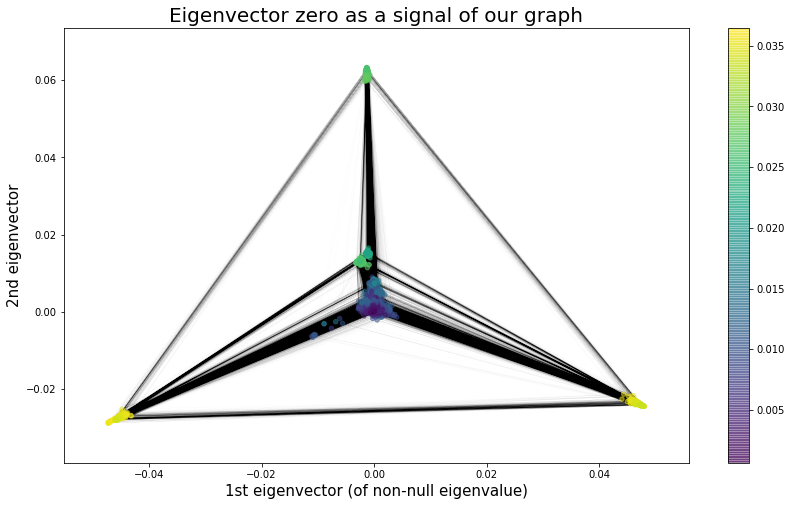

In [55]:
plt.figure(figsize=(14,8))
coords = U_norm_brh[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5, node_size=20, node_color=U_norm_brh[:,0])
nx.draw_networkx_edges(G_brh, coords, alpha=0.003)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

When visualizing the graph on the eigenmap composed by the two smallest eigenvectors corresponding to non-null eigenvalues, we can indeed identify at least 5 major clusters. 3 clusters are especially interesting, the one at the extremities of the graph. Indeed, they form an equilateral triangle, meaning that the repulsion between them is maximal.

These clusters being so clear, we wanted to investigate the underlying features that make them so evident. But before doing that, we were curious to see how in this case (which at first sight seemed promising) the `labels` signal was distributed through the graph. 

## 4.3.2 Signal creation, GFT analysis
[Back to index](#Index)

### Signal creation

In [56]:
label_threshold = 2.5

In [57]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation_brh(threshold):
    labels = np.zeros(n_nodes_bc_brh, dtype=float)
    labels[movies_bc_brh['earnings'] >= threshold] = 1
    labels[movies_bc_brh['earnings'] < threshold] = -1
    return labels

In [58]:
labels_bc_brh = labels_creation_brh(label_threshold)
lab_bc_count_brh = np.unique(labels_bc_brh, return_counts=True)
dict(zip(lab_bc_count_brh[0], lab_bc_count_brh[1]))

{-1.0: 2133, 1.0: 1057}

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


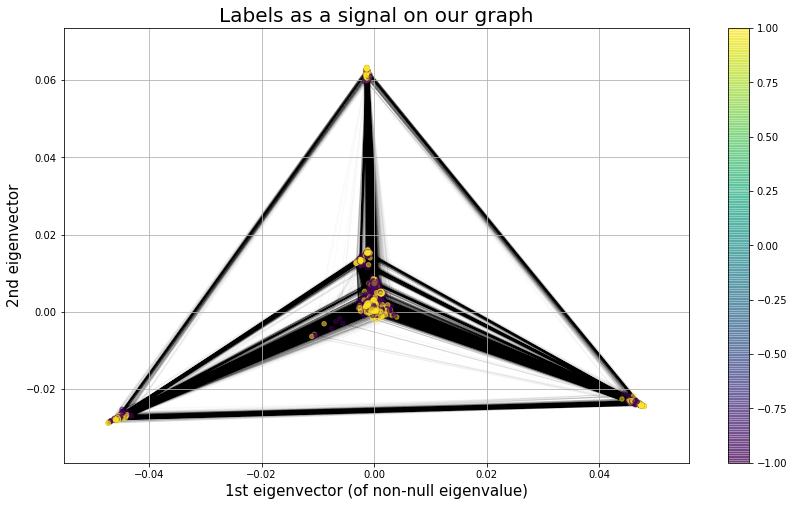

In [59]:
plt.figure(figsize=(14,8))
coords = U_norm_brh[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5, node_size=20, node_color=labels_bc_brh)
nx.draw_networkx_edges(G_brh, coords, alpha=0.01)
plt.title('Labels as a signal on our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);
plt.grid()

### Fourier analysis

<StemContainer object of 3 artists>

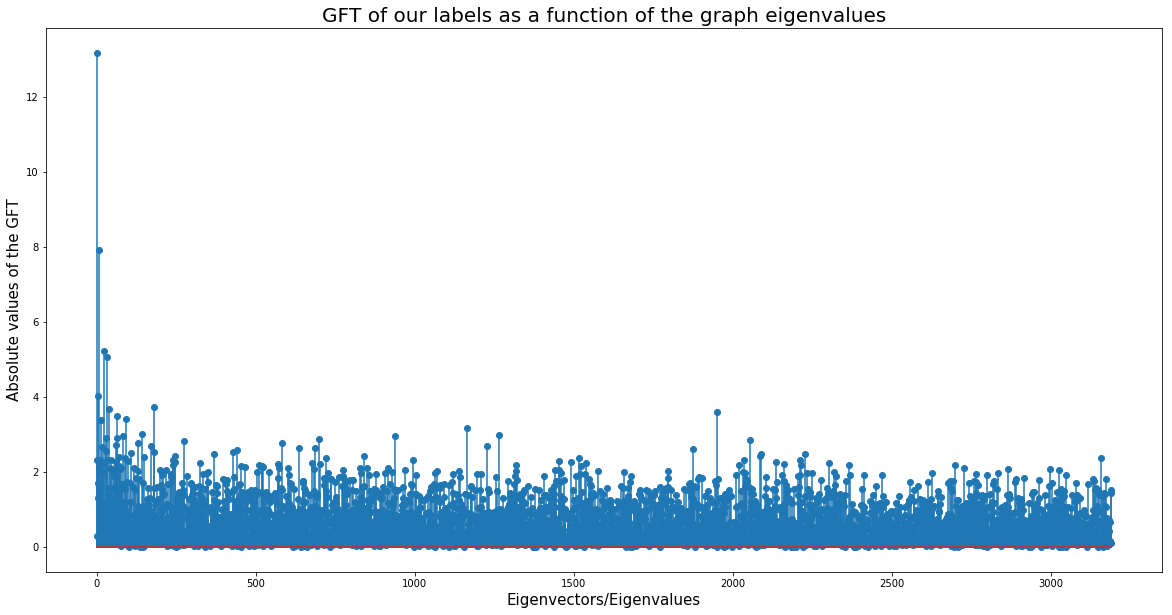

In [60]:
gft = GFT(labels_bc_brh, N_brh, U_norm_brh)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our labels as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)

We can see that our `labels` signal acts as a low_pass filter. à COMPLETER!!!!!!!!!!!!!!!!!!!!!!!!!!!!¨¨

### Visualisation of the signal on laplacian eigenmaps with most representative vectors

In [61]:
# getting the indexes of the eigenvectors with the highest amplitude
index_eig = gft_abs.argsort()[-10:][::-1]
index_eig

array([   0,    8,   22,   32,    4,  181,   38, 1949,   63,   91])

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


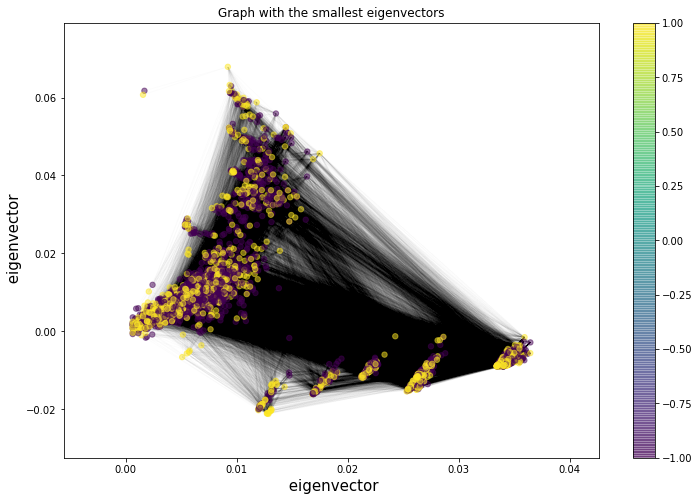

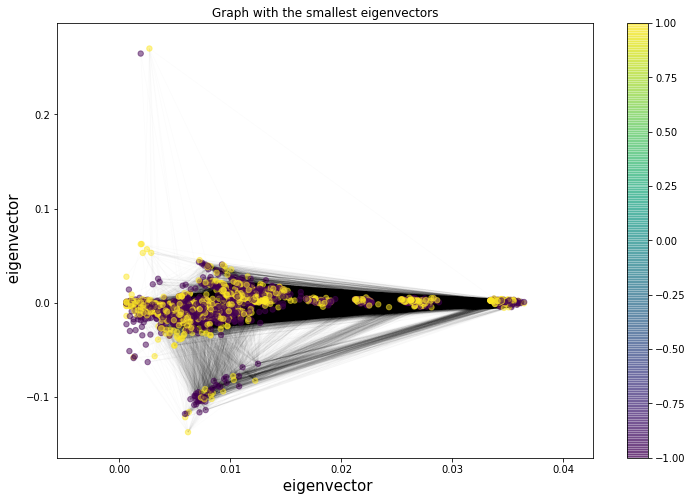

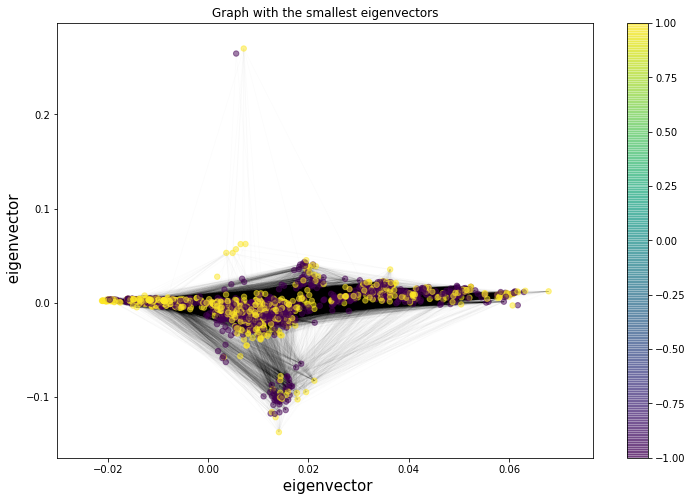

In [62]:
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(12,8))
        coords = U_norm_brh[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5 ,node_size=29, node_color=labels_bc_brh)
        nx.draw_networkx_edges(G_brh, coords, alpha=0.01)
        plt.title('Graph with the smallest eigenvectors')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);

These plots show that even the eigenmaps that best represent our signal does not represent it.

## 4.3.3 Cluster identification
[Back to index](#Index)

The investigation on the content of the clusters is done manullay, taking into account its location on the eigenmap representation.

In [63]:
# Manual check of which of the features are commun within bottom left cluster
list_of_list = np.argwhere(U_norm_brh[:,1]<-0.04).tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
cluster = movies_bc_brh.iloc[flat_list]
cluster.features

# Check the percentages of the movies in the cluster which have been produce by Universal Pictures
subset_wanted = {"Universal Pictures"}
count = cluster.features.apply(subset_wanted.issubset).sum()
percentage = count/len(cluster.features)*100
print("The studied cluster is composed of {} % movies produced by {}" .format(percentage, subset_wanted))

The studied cluster is composed of 100.0 % movies produced by {'Universal Pictures'}


In [64]:
# Manual check of which of the features are commun within bottom right cluster
list_of_list = np.argwhere(U_norm_brh[:,1]>0.04).tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
cluster = movies_bc_brh.iloc[flat_list]
cluster.features

# Check the percentages of the movies in the cluster which have been produce by Paramount Pictures
subset_wanted = {"Paramount Pictures"}
count = cluster.features.apply(subset_wanted.issubset).sum()
percentage = count/len(cluster.features)*100
print("The studied cluster is composed of {} % movies produced by {}" .format(percentage, subset_wanted))

The studied cluster is composed of 100.0 % movies produced by {'Paramount Pictures'}


In [65]:
# Manual check of which of the features are commun within Top cluster
list_of_list = np.argwhere(U_norm_brh[:,2]>0.04).tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
cluster = movies_bc_brh.iloc[flat_list]
cluster.features

# Check the percentages of the movies in the cluster which have been produce by Twentieth Century Fox Film Corporation
subset_wanted = {"Twentieth Century Fox Film Corporation"}
count = cluster.features.apply(subset_wanted.issubset).sum()
percentage = count/len(cluster.features)*100
print("The studied cluster is composed of {} % movies produced by {}" .format(percentage, subset_wanted))

The studied cluster is composed of 100.0 % movies produced by {'Twentieth Century Fox Film Corporation'}


We clearly see that all movies from the most defined cluster are movies produced by the top 3 Production companies. This means that the weigth of the companies is way too much important compared to single individuals, and therefore they bias completely the whole graph. 

## 4.4 BRH-index computation without companies
[Back to index](#Index)

In order to avoid this previoulsy described bias, we decided to erase the companies as features. Thus, a new `features_no_comp` dataframe was created which contained the same features as before (actors, characters, director, producers) but without taking the companies into consideration.

To respect the same structure we used before, the inital method weights are calculated and attributed (despite not being used).

In [66]:
features_no_comp = compute_features_weight(movies_no_comp, 'no_comp')

In [67]:
features_no_comp.head()

,Unnamed: 0,feature,weight
0,0,Larry Mullen Jr.,0.515389
1,1,"""Drugs"" Delaney",0.041739
2,2,"""Hickory"" / The Tin Man",11.155192
3,3,"""Hunk"" / The Scarecrow",11.155192
4,4,"""Whistling"" John Shaw",-0.487703


And then, the BRH index values for this company-free `feature_no_comp` dataframe were calculated.

In [68]:
features_no_comp = pd.concat([features_no_comp, compute_features_brh(movies_no_comp, 'no_comp')['brh_index']], axis=1)

In [69]:
features_no_comp.head()

,Unnamed: 0,feature,weight,brh_index
0,0,Larry Mullen Jr.,0.515389,11.0
1,1,"""Drugs"" Delaney",0.041739,11.0
2,2,"""Hickory"" / The Tin Man",11.155192,11.0
3,3,"""Hunk"" / The Scarecrow",11.155192,11.0
4,4,"""Whistling"" John Shaw",-0.487703,9.0


In [70]:
features_no_comp.sort_values(by='brh_index', ascending=False).head(10)

,Unnamed: 0,feature,weight,brh_index
11167,11167,Joel Silver,1.592479,41.0
2570,2570,Brad Pitt,2.236545,41.0
21367,21367,Steven Spielberg,8.786479,41.0
22170,22170,Tim Bevan,2.616512,37.0
3044,3044,Cameron Diaz,3.241141,36.0
7092,7092,Eric Fellner,2.667155,36.0
20247,20247,Scott Rudin,1.914505,36.0
22364,22364,Tom Hanks,5.591047,36.0
16213,16213,Morgan Freeman,2.868493,36.0
8151,8151,George Clooney,2.097404,36.0


## 4.5 Graph construction: additioning BRH-index without companies
[Back to index](#Index)

Furthermore, a new adjacency matrix (that doesn't take in consideration the companies) needed to be calculated according to the new `feature_no_comp` dataframe. In order to be able to properly compare the graph with the previously obtained with the companies, the way of calculating the edges (in this case additioning) was kept.

## 4.5.1 Adjacency Matrix


In [71]:
adjacency_brh_no_comp = compute_adjacency('adjacency_brh_no_comp.npy', 'brh_index', movies_no_comp, features_no_comp, False)

L_max = 5153655.0
L = 157300
Sparsity = 0.9694779724292759
Average degree =  48.987854251012145


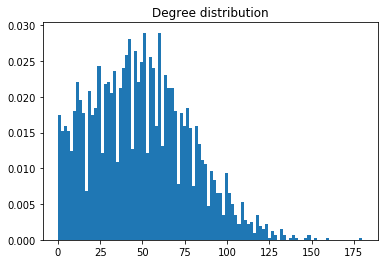

In [72]:
# maximum number of Links in our network
L_max_brh_no_comp = n_nodes*(n_nodes-1)/2
print('L_max =', L_max_brh_no_comp)

# number of link in our network
L_brh_no_comp = np.count_nonzero(adjacency_brh_no_comp)
print('L =',L_brh_no_comp)

# sparisty
sparsity_brh_no_comp = (L_max_brh_no_comp-L_brh_no_comp)/L_max_brh_no_comp
print('Sparsity =', sparsity_brh_no_comp)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary_brh_no_comp = adjacency_brh_no_comp.astype(bool).astype(int)
degree_brh_no_comp =  np.sum(adj_binary_brh_no_comp, axis=0)

print('Average degree = ', np.mean(degree_brh_no_comp))

#Histogram of degree distribution
weights_brh_no_comp = np.ones_like(degree_brh_no_comp) / float(n_nodes)
plt.hist(degree_brh_no_comp, weights=weights_brh_no_comp, bins = 100);
plt.title('Degree distribution');

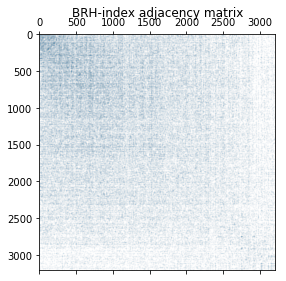

In [73]:
plt.spy(adjacency_brh_no_comp, markersize=0.01)
plt.title('BRH-index adjacency matrix');
plt.tight_layout()

Sparsity is again really high, higher than the last network, because we have taken fewer features to create our edges.

The degree distribution is smoother but also the average degree is smaller, we think that it is because we don't have the companies that link a lot of nodes together. 

## 4.5.2 Biggest component
[Back to index](#Index)

In [74]:
bc_nparray_brh_no_comp, nodes_bc_brh_no_comp = compute_bc('bc_nparray_no_comp.npy', adjacency_brh_no_comp)

In [75]:
n_nodes_bc_brh_no_comp = len(nodes_bc_brh_no_comp)

print('The size of the largest component is {}.'.format(n_nodes_bc_brh_no_comp))

The size of the largest component is 3178.


In [76]:
G_brh_no_comp = nx.from_numpy_array(bc_nparray_brh_no_comp)

print('Clustering coefficient of our Biggest Component = ' ,nx.average_clustering(G_brh_no_comp))

Clustering coefficient of our Biggest Component =  0.29440302253419576


In [77]:
movies_bc_brh_no_comp = movies_no_comp.loc[nodes_bc_brh_no_comp, :]
movies_bc_brh_no_comp['earnings'].describe()

count     3178.000000
mean        10.196851
std        241.311362
min         -0.999744
25%          0.030190
50%          1.301077
75%          3.396980
max      12889.386667
Name: earnings, dtype: float64

## 4.6 Analysis and visualisation
[Back to index](#Index)

## 4.6.1 Graph visualisation on eigenmaps

In [78]:
degree_biggest_component_brh_no_comp= np.sum(bc_nparray_brh_no_comp, axis=0)

N_brh_no_comp = n_nodes_bc_brh_no_comp  # number of nodes
E_brh_no_comp = np.sum(bc_nparray_brh_no_comp > 0)  # number of edges (non-zero entries of A)

sparse_gradient_brh_no_comp, sparse_laplacian_brh_no_comp = compute_gradient_laplacian('gradient_brh_no_comp.npz', bc_nparray_brh_no_comp, degree_biggest_component_brh_no_comp, N_brh_no_comp, E_brh_no_comp)

In [79]:
eigenvalues_brh_no_comp, eigenvectors_brh_no_comp = np.linalg.eigh(sparse_laplacian_brh_no_comp.toarray())
e_brh_no_comp = eigenvalues_brh_no_comp
U_brh_no_comp = eigenvectors_brh_no_comp

D_brh_no_comp = np.diag(degree_biggest_component_brh_no_comp)
D_inv_brh_no_comp = np.divide(1,D_brh_no_comp)
D_inv_brh_no_comp[D_inv_brh_no_comp == np.inf] = 0
D_sqrtinv_brh_no_comp = scipy.linalg.sqrtm(D_inv_brh_no_comp)

#Renormalized by the degrees
U_norm_brh_no_comp = D_sqrtinv_brh_no_comp@U_brh_no_comp

# Normalize the rows of U_norm
rows_norm_brh_no_comp = np.linalg.norm(U_norm_brh_no_comp, axis=1, ord=2)
U_norm_brh_no_comp = (U_norm_brh_no_comp.T / rows_norm_brh_no_comp).T

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


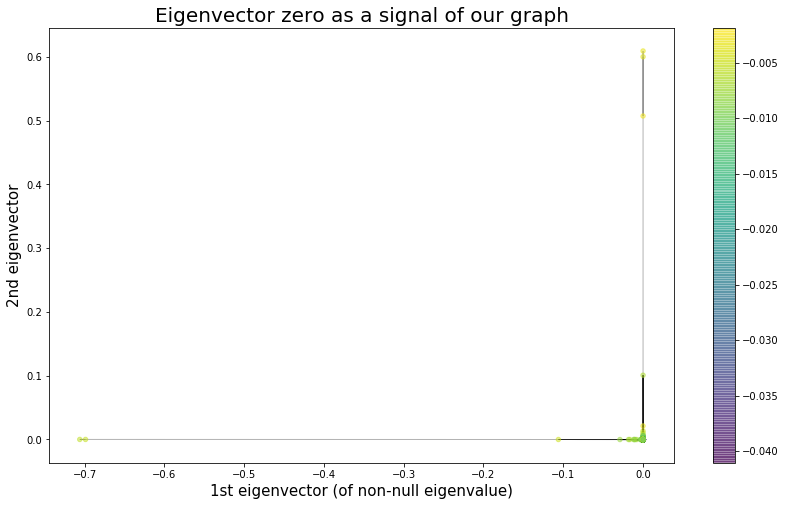

In [114]:
plt.figure(figsize=(14,8))
coords = U_norm_brh_no_comp[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp, coords,alpha=0.5, node_size=20, node_color=U_norm_brh_no_comp[:,0])
nx.draw_networkx_edges(G_brh_no_comp, coords, alpha=0.3)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

# EXPLIQUER QUELQUE CHOSE

## 4.6.2 Signal creation, GFT analysis
[Back to index](#Index)

### Signal creation

In [81]:
label_threshold = 4

In [82]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation_brh_no_comp(threshold):
    labels = np.zeros(n_nodes_bc_brh_no_comp, dtype=float)
    labels[movies_bc_brh_no_comp['earnings'] >= threshold] = 1
    labels[movies_bc_brh_no_comp['earnings'] < threshold] = -1
    return labels

In [83]:
labels_bc_brh_no_comp = labels_creation_brh_no_comp(label_threshold)
lab_bc_count_brh_no_comp = np.unique(labels_bc_brh_no_comp, return_counts=True)
dict(zip(lab_bc_count_brh_no_comp[0], lab_bc_count_brh_no_comp[1]))

{-1.0: 2499, 1.0: 679}

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


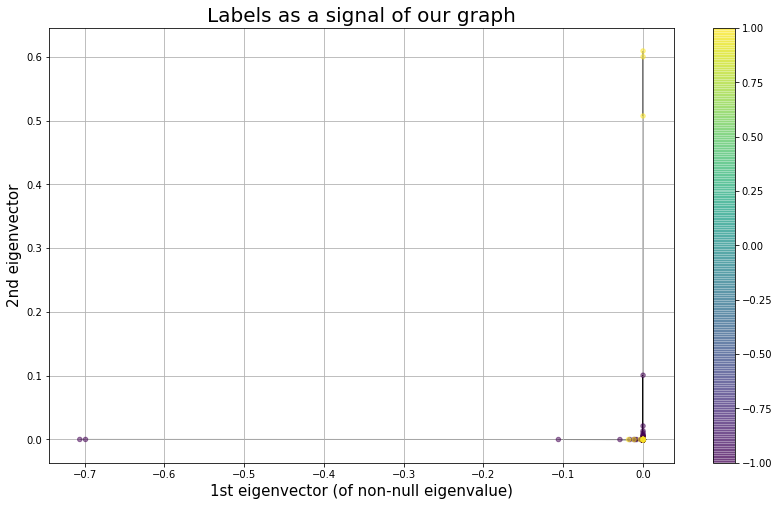

In [113]:
plt.figure(figsize=(14,8))
coords = U_norm_brh_no_comp[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp, coords,alpha=0.5, node_size=20, node_color=labels_bc_brh_no_comp)
nx.draw_networkx_edges(G_brh_no_comp, coords, alpha=0.5)
plt.title('Labels as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);
plt.grid()

### Fourier analysis

<StemContainer object of 3 artists>

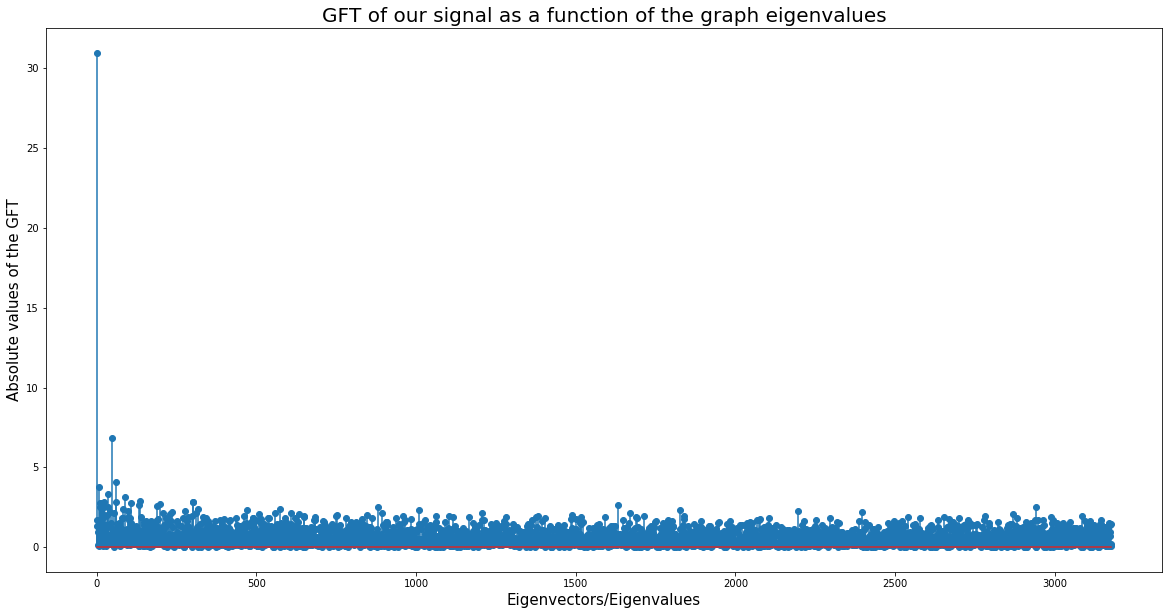

In [85]:
gft = GFT(labels_bc_brh_no_comp, N_brh_no_comp, U_norm_brh_no_comp)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our signal as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)

### Visualisation of the signal on laplacian eigenmaps with most representative vectors

In [86]:
# getting the indexes of the eigenvectors with the highest amplitude
index_eig = gft_abs.argsort()[-10:][::-1]
index_eig

array([  0,  49,  59,   7,  35,  89, 137, 302, 303,  60])

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


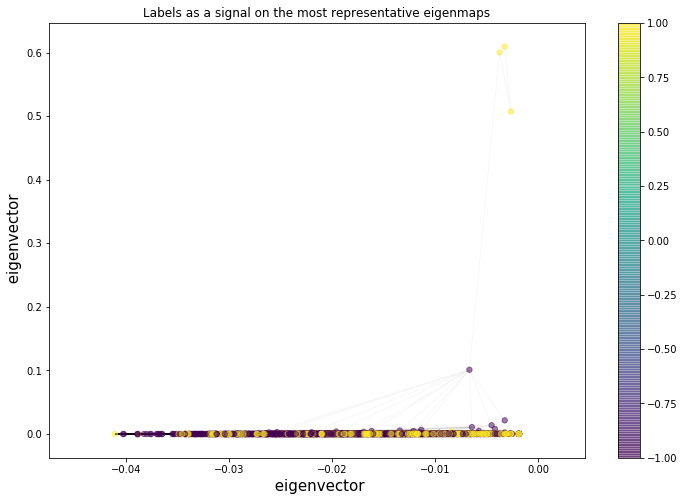

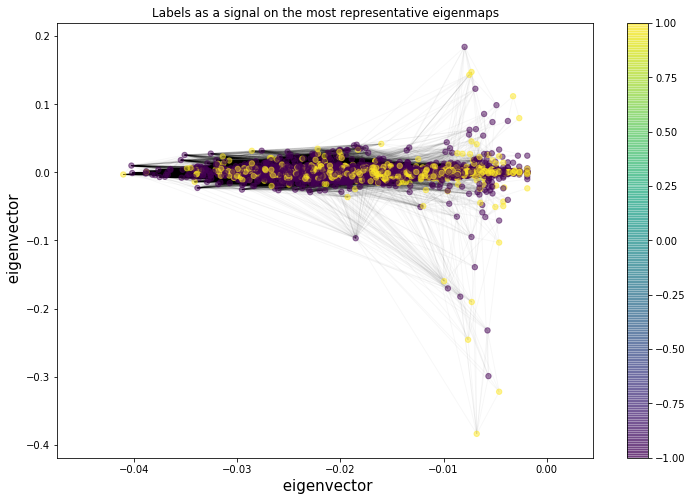

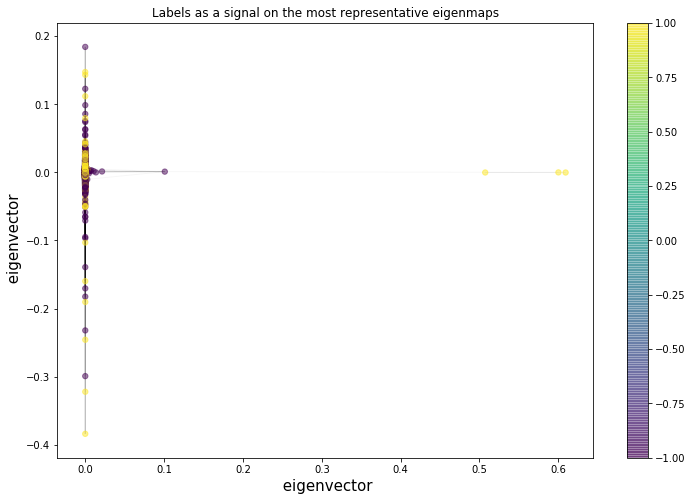

In [110]:
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(12,8))
        coords = U_norm_brh_no_comp[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp, coords,alpha=0.5 ,node_size=29, node_color=labels_bc_brh_no_comp)
        nx.draw_networkx_edges(G_brh_no_comp, coords, alpha=0.03)
        plt.title('Labels as a signal on the most representative eigenmaps')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);

## 4.7 Graph construction: averaging BRH-index without companies
[Back to Index](#Index)

## 4.7.1 Adjacency Matrix


In [88]:
adjacency_brh_no_comp_avg = compute_adjacency('adjacency_brh_no_comp_avg.npy', 'brh_index', movies_no_comp, features_no_comp, True)

L_max = 5153655.0
L = 157300
Sparsity = 0.9694779724292759
Average degree =  48.987854251012145


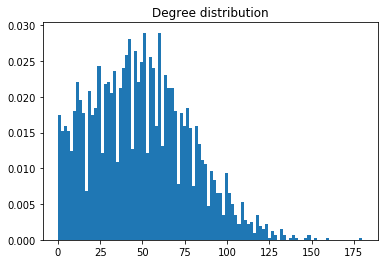

In [89]:
# maximum number of Links in our network
L_max_brh_no_comp_avg = n_nodes*(n_nodes-1)/2
print('L_max =', L_max_brh_no_comp_avg)

# number of link in our network
L_brh_no_comp_avg = np.count_nonzero(adjacency_brh_no_comp_avg)
print('L =',L_brh_no_comp_avg)

# sparisty
sparsity_brh_no_comp_avg = (L_max_brh_no_comp_avg-L_brh_no_comp_avg)/L_max_brh_no_comp_avg
print('Sparsity =', sparsity_brh_no_comp_avg)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary_brh_no_comp_avg = adjacency_brh_no_comp_avg.astype(bool).astype(int)
degree_brh_no_comp_avg =  np.sum(adj_binary_brh_no_comp_avg, axis=0)

print('Average degree = ', np.mean(degree_brh_no_comp_avg))


#Histogram of degree distribution
weights_brh_no_comp_avg = np.ones_like(degree_brh_no_comp_avg) / float(n_nodes)
plt.hist(degree_brh_no_comp_avg, weights=weights_brh_no_comp_avg, bins = 100);
plt.title('Degree distribution');

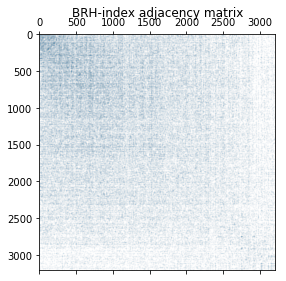

In [90]:
plt.spy(adjacency_brh_no_comp_avg, markersize=0.01)
plt.title('BRH-index adjacency matrix');
plt.tight_layout()

In [91]:
np.mean(degree_brh_no_comp_avg)

48.987854251012145

Sparsity is again really high and the degree distribution is no different that the previous network created by additioning the brh indexes. As the change has no effect on the degree of the nodes but on the edges of the weights.

## 4.7.2 Biggest component
[Back to Index](#Index)

In [92]:
bc_nparray_brh_no_comp_avg, nodes_bc_brh_no_comp_avg = compute_bc('bc_nparray_no_comp_avg.npy', adjacency_brh_no_comp_avg)

In [93]:
n_nodes_bc_brh_no_comp_avg = len(nodes_bc_brh_no_comp_avg)

print('The size of the largest component is {}.'.format(n_nodes_bc_brh_no_comp_avg))

The size of the largest component is 3178.


In [94]:
G_brh_no_comp_avg = nx.from_numpy_array(bc_nparray_brh_no_comp_avg)

print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G_brh_no_comp_avg))

Clustering coefficient of our Biggest Component = 0.29440302253419576


In [95]:
movies_bc_brh_no_comp_avg = movies_no_comp.loc[nodes_bc_brh_no_comp_avg, :]
movies_bc_brh_no_comp_avg['earnings'].describe()

count     3178.000000
mean        10.196851
std        241.311362
min         -0.999744
25%          0.030190
50%          1.301077
75%          3.396980
max      12889.386667
Name: earnings, dtype: float64

## 4.8 Analysis and visualisation
[Back to Index](#Index)

## 4.8.1 Graph visualisation on eigenmaps


In [96]:
degree_biggest_component_brh_no_comp_avg= np.sum(bc_nparray_brh_no_comp_avg, axis=0)

N_brh_no_comp_avg = n_nodes_bc_brh_no_comp_avg  # number of nodes
E_brh_no_comp_avg = np.sum(bc_nparray_brh_no_comp_avg > 0)  # number of edges (non-zero entries of A)

sparse_gradient_brh_no_comp_avg, sparse_laplacian_brh_no_comp_avg = compute_gradient_laplacian('gradient_brh_no_comp_avg.npz', bc_nparray_brh_no_comp_avg, degree_biggest_component_brh_no_comp_avg, N_brh_no_comp_avg, E_brh_no_comp_avg)

In [97]:
eigenvalues_brh_no_comp_avg, eigenvectors_brh_no_comp_avg = np.linalg.eigh(sparse_laplacian_brh_no_comp_avg.toarray())
e_brh_no_comp_avg = eigenvalues_brh_no_comp_avg
U_brh_no_comp_avg = eigenvectors_brh_no_comp_avg

D_brh_no_comp_avg = np.diag(degree_biggest_component_brh_no_comp_avg)
D_inv_brh_no_comp_avg = np.divide(1,D_brh_no_comp_avg)
D_inv_brh_no_comp_avg[D_inv_brh_no_comp_avg == np.inf] = 0
D_sqrtinv_brh_no_comp_avg = scipy.linalg.sqrtm(D_inv_brh_no_comp_avg)

#Renormalized by the degrees
U_norm_brh_no_comp_avg = D_sqrtinv_brh_no_comp_avg@U_brh_no_comp_avg

# Normalize the rows of U_norm
rows_norm_brh_no_comp_avg = np.linalg.norm(U_norm_brh_no_comp_avg, axis=1, ord=2)
U_norm_brh_no_comp_avg = (U_norm_brh_no_comp_avg.T / rows_norm_brh_no_comp_avg).T

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


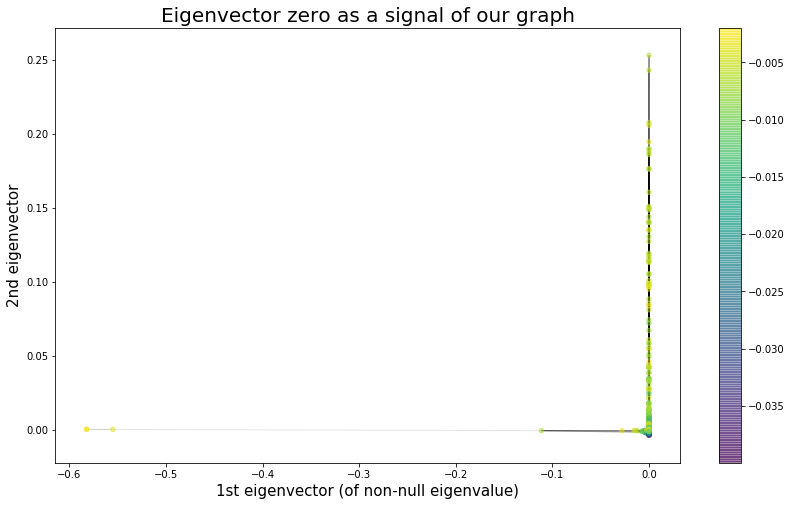

In [111]:
plt.figure(figsize=(14,8))
coords = U_norm_brh_no_comp_avg[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp_avg, coords,alpha=0.5, node_size=20, node_color=U_norm_brh_no_comp_avg[:,0])
nx.draw_networkx_edges(G_brh_no_comp_avg, coords, alpha=0.1)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

## 4.8.2 Signal creation, GFT analysis
[Back to Index](#Index)

### Signal creation

In [99]:
label_threshold = 1

In [100]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation_brh_no_comp_avg(threshold):
    labels = np.zeros(n_nodes_bc_brh_no_comp_avg, dtype=float)
    labels[movies_bc_brh_no_comp_avg['earnings'] >= threshold] = 1
    labels[movies_bc_brh_no_comp_avg['earnings'] < threshold] = -1
    return labels

In [101]:
labels_bc_brh_no_comp_avg = labels_creation_brh_no_comp_avg(label_threshold)
lab_bc_count_brh_no_comp_avg = np.unique(labels_bc_brh_no_comp_avg, return_counts=True)
dict(zip(lab_bc_count_brh_no_comp_avg[0], lab_bc_count_brh_no_comp_avg[1]))

{-1.0: 1395, 1.0: 1783}

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


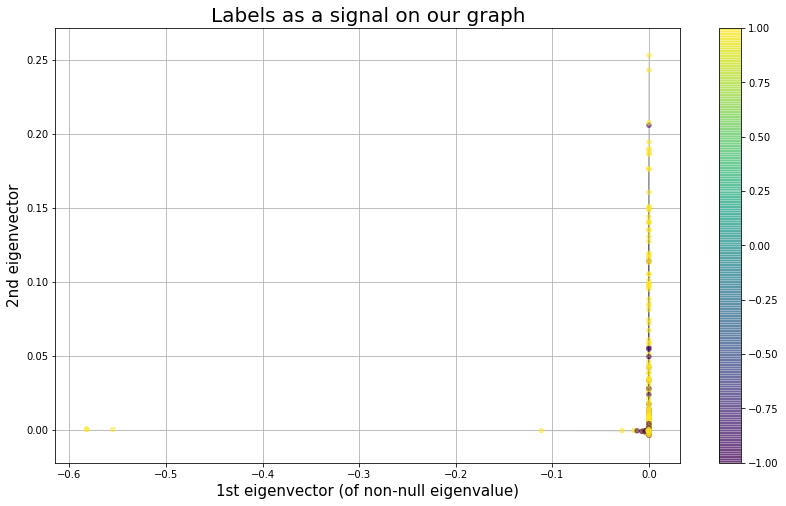

In [102]:
plt.figure(figsize=(14,8))
coords = U_norm_brh_no_comp_avg[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp_avg, coords,alpha=0.5, node_size=20, node_color=labels_bc_brh_no_comp_avg)
nx.draw_networkx_edges(G_brh_no_comp_avg, coords, alpha=0.01)
plt.title('Labels as a signal on our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);
plt.grid()

### Fourier Analysis

<StemContainer object of 3 artists>

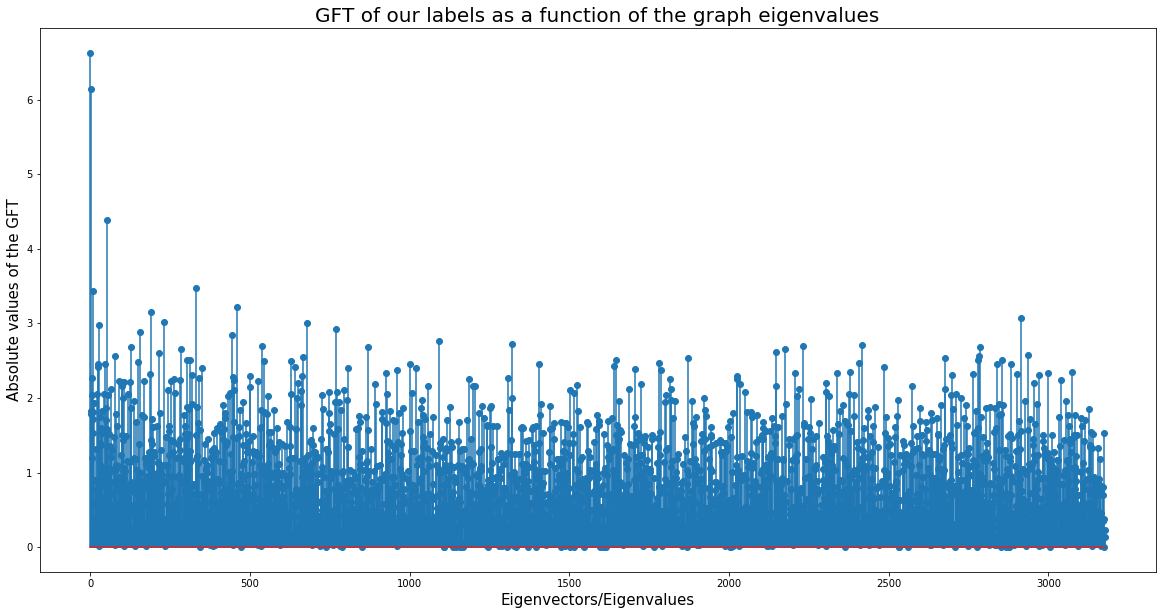

In [103]:
gft = GFT(labels_bc_brh_no_comp_avg, N_brh_no_comp_avg, U_norm_brh_no_comp_avg)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our labels as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)

### Visualisation of the signal on laplacian eigenmaps with most representative vectors

In [104]:
index_eig = gft_abs.argsort()[-10:][::-1]

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


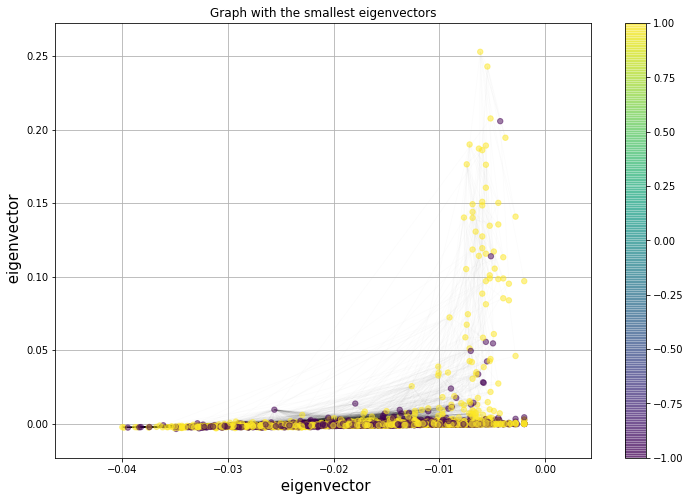

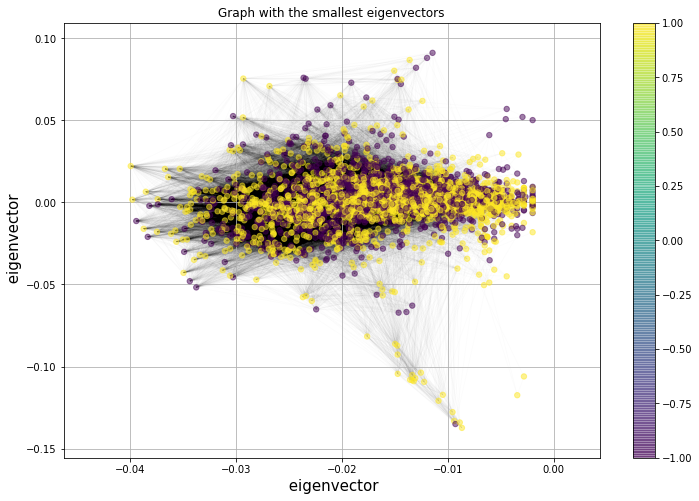

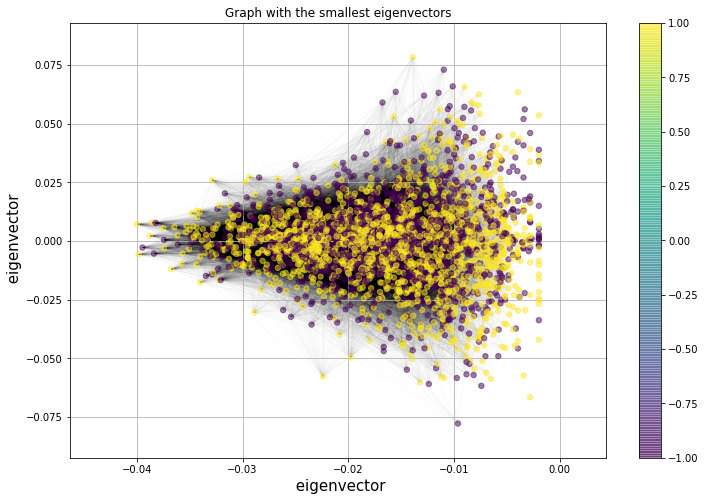

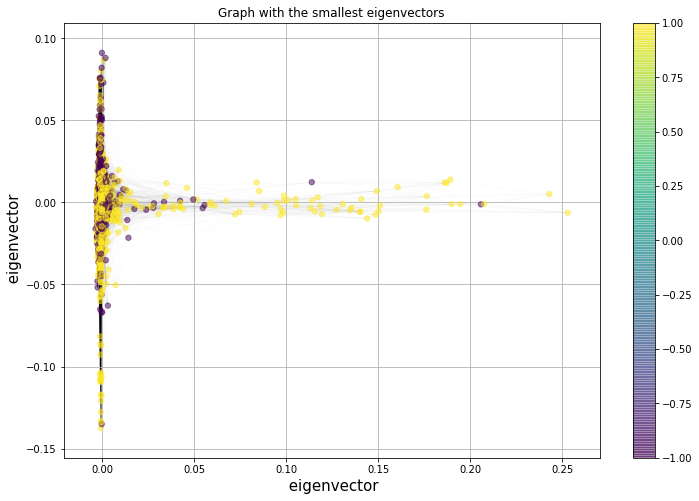

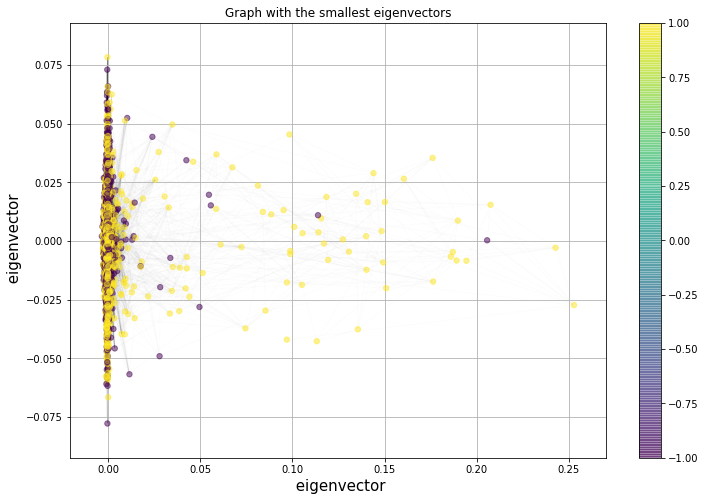

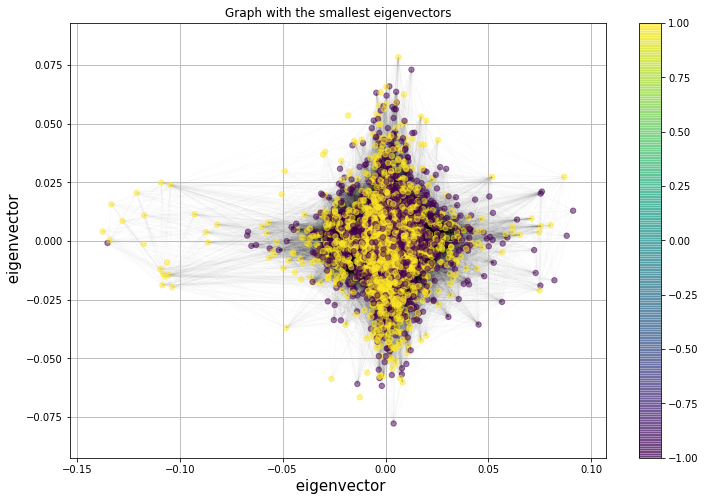

In [105]:
for i in range(4):
    for j in range(i+1,4):
        plt.figure(figsize=(12,8))
        coords = U_norm_brh_no_comp_avg[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp_avg, coords,alpha=0.5 ,node_size=29, node_color=labels_bc_brh_no_comp_avg)
        nx.draw_networkx_edges(G_brh_no_comp_avg, coords, alpha=0.01)
        plt.title('Graph with the smallest eigenvectors')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);
        plt.grid()

In [106]:
# Manual check of which of the features are commun within cluster
list_of_list = np.argwhere(U_norm_brh_no_comp_avg[:,index_eig[2]]>0.01).tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
cluster = movies_bc_brh_no_comp.iloc[flat_list]
cluster.head(10)

,original_title,earnings,features
3,The Dark Knight Rises,3.339756,"[Christian Bale, Michael Caine, Gary Oldman, A..."
4,John Carter,0.092843,"[Taylor Kitsch, Lynn Collins, Samantha Morton,..."
7,Avengers: Age of Ultron,4.019299,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff..."
16,The Avengers,5.907081,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,..."
18,Men in Black 3,1.773452,"[Will Smith, Tommy Lee Jones, Josh Brolin, Mic..."
24,King Kong,1.657005,"[Naomi Watts, Jack Black, Adrien Brody, Thomas..."
26,Captain America: Civil War,3.613218,"[Chris Evans, Robert Downey Jr., Scarlett Joha..."
31,Iron Man 3,5.077200,"[Robert Downey Jr., Gwyneth Paltrow, Don Chead..."
40,Cars 2,1.799262,"[Owen Wilson, Larry the Cable Guy, Michael Cai..."
58,Rush Hour 3,0.843016,"[Chris Tucker, Jackie Chan, Hiroyuki Sanada, M..."


In [107]:
cluster.describe()

,earnings
count,621.000000
mean,2.968840
std,12.550169
min,-0.999126
25%,-0.063733
50%,1.046671
75%,2.848268
max,249.000000


In [108]:
list_of_list = cluster.features.tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
actors = pd.DataFrame(flat_list)
actors.columns = ['actor']
appearences = actors.actor.value_counts()
appearences

Robert Rodriguez                 30
Matt Damon                       30
Mel Gibson                       22
Woody Harrelson                  21
Owen Wilson                      21
Will Smith                       20
Angelina Jolie                   20
Michael Douglas                  20
Jackie Chan                      18
Gary Oldman                      18
George Clooney                   17
Antonio Banderas                 17
Vin Diesel                       17
Dwayne Johnson                   17
Colin Farrell                    17
Sandra Bullock                   17
Gerard Butler                    17
Kevin Smith                      16
Jack Black                       16
Pierce Brosnan                   16
Reese Witherspoon                16
Elizabeth Banks                  15
Robert Downey Jr.                15
Bruce Willis                     15
Seann William Scott              14
Roger Birnbaum                   14
Jessica Alba                     14
Rob Reiner                  